# Wet dry model intercomparison

The target of this notebook is to compare several algorithms from PyNNCML and pycomlink on open datasets using poligrain.

## Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

# Poligrain for example data
import poligrain as plg

In [2]:
# include local submodules as packages
for submodule_name in ['PyNNcml',"pycomlink"]:
    sys.path.append(os.path.join(os.getcwd(), submodule_name))
    
from pynncml.cml_methods.apis.xarray_processing.wet_dry_methods import create_wet_dry_std
from pycomlink.processing.pytorch_utils.run_inference import cnn_wd

# Other methods to be tested?
#from pycomlink.processing.tensorflow_utils import run_inference
#from pycomlink.processing.wet_dry import stft
#from pycomlink.processing.wet_dry import nearby_wet_dry
#from pycomlink.processing.wet_dry import mlp
#from pynncml.cml_methods.apis.xarray_processing.wet_dry_methods import create_wet_dry_dnn_gru


c:\Users\lukas\Documents\OpenSense\bench-deep-cml\PyNNcml\pynncml\model_zoo\model_common.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
c:\Users\lukas\miniforge3\envs\bench-deep-cml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load OpenMRG Dataset

In [3]:
# OpenMRG Dataset from Poligrain
( ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

# Calculate total loss (previous TRSL)
ds_cmls['tl'] = ds_cmls.tsl - ds_cmls.rsl 

# Ensure, the reference rain amount array shape is (time, channels, cml_id)
ds_cmls['R'] = ds_cmls.R.transpose('time', 'sublink_id', 'cml_id')
ds_cmls['ref_wd'] = ds_cmls.R.where(ds_cmls.R == 0, True).astype(bool)

# TEMPORARY: select only 3 different CMLs to save memory
ds_cmls = ds_cmls.isel(cml_id = [0, 10, 180])

File already exists at example_data\openmrg_cml_8d.nc
Not downloading!
File already exists at example_data\openmrg_rad_8d.nc
Not downloading!
File already exists at example_data\openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data\openmrg_smhi_gauge_8d.nc
Not downloading!


## Methods inference
___  
### A: Wet Dry Classification using Std from PyNNCML

In [4]:
# Run STD Wet/Dry classification
wd_std=create_wet_dry_std(threshold=0.2)
std_wet_dry = wd_std(ds_cmls)

ds_cmls['std_wd'] = std_wet_dry.wet_dry_detection

___  
### B: Wet Dry Classification using Pycomlink PyTorch CNN, Polz_2020

In [5]:
# Ensure, the TL dataarray shape is (time, channels, cml_id)
tl = ds_cmls.tl.transpose('time', 'sublink_id', 'cml_id')

# Normalisation
tl_normed = tl - tl.median(dim='time')

In [6]:
# CNN inference
model_URL = "https://github.com/jpolz/cml_wd_pytorch/raw/be2b15fa987838ea1f709dd0180917eebf66271a/data/dummy_model/best_model_jit.pt"
cnn_wet_dry = cnn_wd(model_URL,data=tl_normed)

# Create binary wet/dry classification from probabilistic output
cnn_wd_threshold = 0.8
ds_cmls['cnn_pred'] = (('time','cml_id'), cnn_wet_dry.predictions.values)
ds_cmls['cnn_wd'] = (('time','cml_id'), cnn_wet_dry.predictions.values > cnn_wd_threshold)

Using cached model at C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt
✅ Loaded exported model from: C:\Users\lukas\.cml_wd_pytorch\models\model_82cadc59c69484be44b1bd4226e1afe4.pt


___  
### Add new methods here...

## Result comparison
___  
### Plot the prediction outputs

In [1]:
# TODO: unify plot for all methods
# TODO: more detailed plots with probabilities, thresholds, etc.
# TODO: compare results with gauge reference

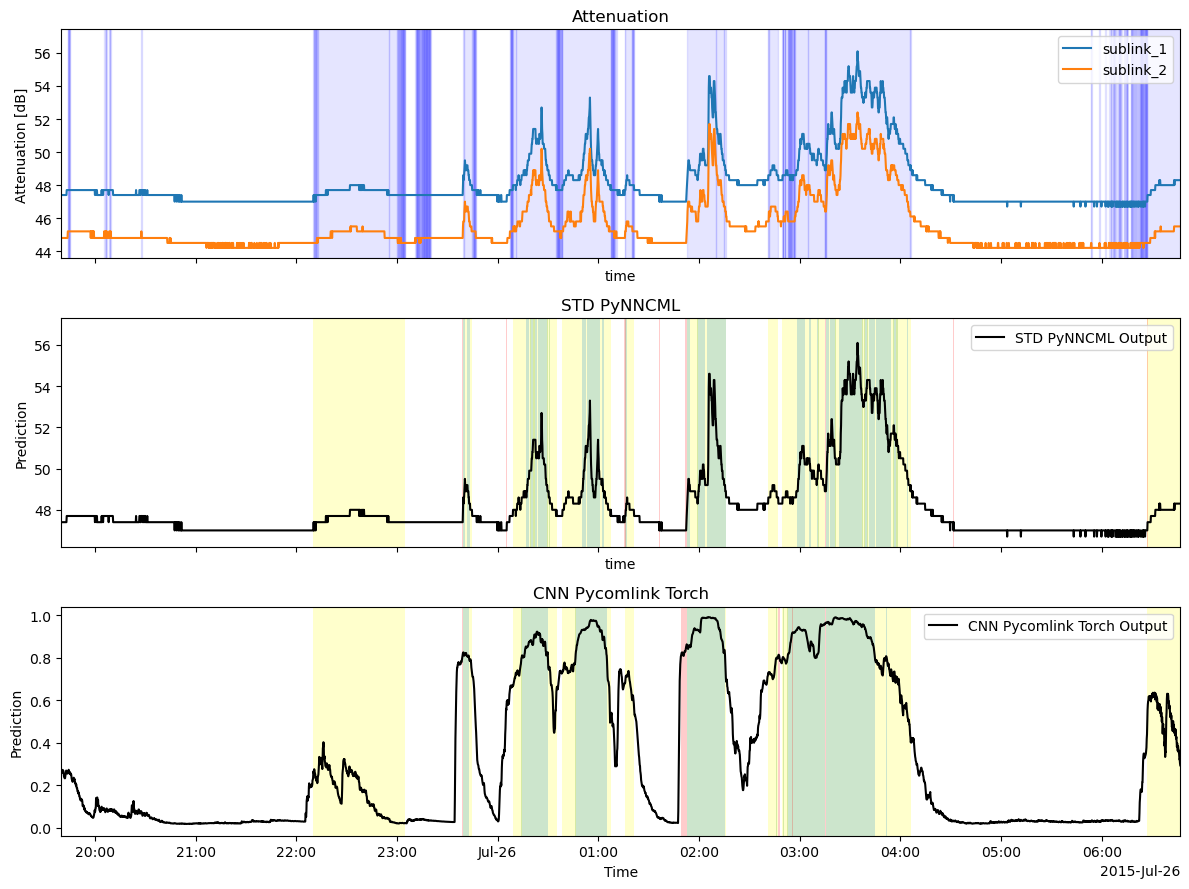

In [15]:
# Select CML index to plot
cml_id = 0 
cml = ds_cmls.isel(cml_id=cml_id)
ref_wd = cml.ref_wd.isel(sublink_id=0).values.astype(bool)

outputs = {
    'STD PyNNCML': cml.tl.isel(sublink_id=0),
    'CNN Pycomlink Torch': cml.cnn_pred,
    # add new method here
}
wetdry = {
    'STD PyNNCML': cml.isel(sublink_id=0).std_wd.values.astype(bool),
    'CNN Pycomlink Torch': cml.cnn_wd.values.astype(bool),
    # add new method here
}

fig, axs = plt.subplots(nrows=len(outputs)+1, figsize=(12,3*(len(outputs)+1)), sharex=True)

# First subplot: attenuation
cml.tl.plot.line(x='time', ax=axs[0], label=cml.sublink_id.values)
axs[0].set_ylabel('Attenuation [dB]')
axs[0].set_title('Attenuation')
axs[0].legend(loc='upper right')

# Get start and end of dry event
wet_start = np.roll(cml.ref_wd, -1) & ~cml.ref_wd
wet_end = np.roll(cml.ref_wd, 1) & ~cml.ref_wd
for wet_start_i, wet_end_i in zip(
    wet_start.values.nonzero()[0],
    wet_end.values.nonzero()[0],
):
    axs[0].axvspan(cml.time.values[wet_start_i], cml.time.values[wet_end_i], color='b', alpha=0.1)

# Plot reference rain rate on secondary y-axis
#ax_rain = axs[0].twinx()
#ax_rain.plot(cml.time.values, ref_rain, color='black', label='gauge Rain rate [mm]')


# Subplots: prediction outputs with shaded TP/FN/FP
for idx, (name, wd) in enumerate(wetdry.items(), start=1):
    outputs[name].plot.line(x='time', ax=axs[idx], label=f'{name} Output', color='black')
    axs[idx].set_ylabel('Prediction')
    axs[idx].set_title(name)

    TP = wd & ref_wd
    FN = ~wd & ref_wd
    FP = wd & ~ref_wd

    for flag, color in zip([TP, FN, FP], ['green', 'yellow', 'red']):
        start = np.roll(flag, -1) & ~flag
        end = np.roll(flag, 1) & ~flag
        for start_i, end_i in zip(
            start.nonzero()[0],
            end.nonzero()[0],
        ):
            axs[idx].axvspan(cml.time.values[start_i], cml.time.values[end_i], color=color, alpha=0.2,linewidth=0)


    axs[idx].legend(loc='upper right')
    
[ax.set_xlim(cml.time[33000], cml.time[37000]) for ax in axs] 
#[ax.set_xlim(cml.time[0], cml.time[-1]) for ax in axs]    # Fit x scale to full plot width

plt.xlabel('Time')
plt.tight_layout()
plt.show()


___
### Performance metrics

In [ ]:

# TODO: Other intercomparison metrics: ACC, Correction Matrix, MCC, F1-score, ROC-AUC, 

# Common metrics for binary classifier comparison:
# - Accuracy (ACC)
# - Confusion Matrix
# - Precision
# - Recall (Sensitivity, True Positive Rate)
# - Specificity (True Negative Rate)
# - F1-score
# - Matthews Correlation Coefficient (MCC)
# - ROC Curve and Area Under Curve (ROC-AUC)
# - Precision-Recall Curve and AUC
# - Balanced Accuracy
# - Cohen's Kappa